# Baseline FMDT one sample at a time


In [1]:
from pylab import *
import matplotlib as mpl
import seaborn as sns
import calc11
import numpy as np
from scipy import constants
import fdmt # you'll need to have ../python in  you PYTHONPATH
from graphviz import Digraph
from collections import OrderedDict


%matplotlib inline

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(r.scans[0].polys[0])? (calc11.py, line 229)

In [ ]:
fc = 1.12 # center frequency GHz
bw = 0.288 # bandwidth GHz
Nd = 4 # number of DM trials
Nchan= 4
Nt = 256 # time block size
Tint = 0.864e-3 # integration time - seconds
Npol = 2 # input number of polarisations
Npix = 256
ignore_ant = ['ak31','ak32','ak33','ak34','ak35','ak36']
f1 = fc - bw/2.
f2 = fc + bw/2.
chanbw = 1e-3
lam1 = constants.c/f1/1e9
lam2 = constants.c/f2/1e9
freqs = f1 + np.arange(Nchan)*chanbw
lambdas = constants.c / (freqs*1e9)
nbytes = 2


print lam1, lam2, lambdas.min(), lambdas.max(), freqs.min(), freqs.max()

In [ ]:
thefdmt = fdmt.Fdmt(f1, chanbw, Nchan, Nd, Nt)
print(dir(thefdmt))


In [3]:
def fmt(i,c,d):
    return 'I{}D{}C{}'.format(i,d,c)

maindot = Digraph(comment='FDMT', format='png')
all_offsets = []
nnodes = 0
nplotnodes = 0
output_fifo_sizes = {}

# make initial nodes
ishape = thefdmt.hist_state_shape[0]
dot = Digraph(name='cluster_iter0')
dot.attr(label='Iteration 0')
maindot.subgraph(dot)
for c in xrange(ishape[0]):
    for d in xrange(ishape[1]):
        maindot.node(fmt(0, c, d))
        nnodes += 1
        nplotnodes += 1

        
for iterno, nfd in enumerate(thefdmt.hist_nf_data):
    out_shape = thefdmt.hist_state_shape[iterno+1]
    in_shape = thefdmt.hist_state_shape[iterno]
    nchan, ndt, nt_out = out_shape
    print 'Iteration {} in={}={} out={}={}'.format(iterno, in_shape, in_shape[0:2].prod(), out_shape, out_shape[:2].prod())
    dot = Digraph(name='cluster_iter{}'.format(iterno+1))
    dot.attr(label='Iteration {}'.format(iterno+1))
    maindot.subgraph(dot)

    for ochan in xrange(nchan):
        chanconfig = thefdmt.hist_nf_data[iterno][ochan][-1]
        #print '\tOut channel {}'.format(ochan)
        last_id1 = -1
        last_id2 = -1
        for idt, config in enumerate(chanconfig):
            _, id1, offset, id2, _, _, _ = config
            do_copy = id2 == -1
            inchan1 = 2*ochan
            inchan2 = inchan1+1
            id1_hit = ''
            id2_hit = ''
            if last_id1 == id1:
                id1_hit = '*'
            if last_id2 == id2:
                id2_hist = '*'
            
            #print '\t Out Channel {} idout={} from chan{}/idt{}{} + chan{}/idt{}{} with offset {}' \
            #    .format(ochan, idt, inchan1, id1, id1_hit, inchan2, id2, id2_hit, offset)
            
            all_offsets.append(offset)
            style = 'dashed' if do_copy else 'solid'
            nnodes += 1
            label = None if offset == 0 else 'd={}'.format(offset)
            n1 = fmt(iterno, inchan1, id1)
            n2 = fmt(iterno, inchan2, id2)
            nout = fmt(iterno+1,ochan, idt)
            
            # For a given sum - only maintain 1 fifo of the given max length
            ff = output_fifo_sizes.get(n2, [])
            ff.append(offset)
            output_fifo_sizes[n2] = ff
            
            #addnode = iterno >= 6 and idt > thefdmt.hist_state_shape[iterno+1][1]*0.9
            addnode = True
            if addnode:
                maindot.node(fmt(iterno+1,ochan, idt), style=style)
                nplotnodes += 1
                maindot.edge(n1, nout)
                if not do_copy:
                    color = 'black' if offset == 0 else 'red'
                    maindot.edge(n2, nout,label=label, color=color)
    
            last_id1 = id1
            last_id2 = id2

    
nfifo_outputs = {k:max(ff) for k, ff in output_fifo_sizes.iteritems()}
bulk_fifo_sizes = {k:min(ff) for k, ff in output_fifo_sizes.iteritems()}
fanout_fifo_sizes = {k:max(ff) - min(ff) for k, ff in output_fifo_sizes.iteritems()}

print 'Total offsets', sum(all_offsets), 'nfifo outputs', sum(nfifo_outputs.values()), 'largest fifo', max(nfifo_outputs.values()), 'total nodes', nnodes

SyntaxError: invalid syntax (<ipython-input-3-a97c98e522d3>, line 26)

In [23]:
print 'nplotnodes', nplotnodes
if nplotnodes < 1200:
    maindot.view()
    
print all_offsets

nplotnodes 18
[0, 1, 1, 0, 1, 1, 0, 1, 1, 2]


******** total
Total SR entries 7
Number of SR length ==0 0
Number of SR length ==1 5
Number of SR length ==2 1
Number of SR length >=1 6
Number of SR length <=16 6
Number of SR length <=32 6
Number of SR length <=64 6
Number of SR length >64 0
Number of SR length >128 0
Number of SR length >256 0
Number of SR length >512 0
Max SR length 2
******** bulk
Total SR entries 3
Number of SR length ==0 3
Number of SR length ==1 3
Number of SR length ==2 0
Number of SR length >=1 3
Number of SR length <=16 6
Number of SR length <=32 6
Number of SR length <=64 6
Number of SR length >64 0
Number of SR length >128 0
Number of SR length >256 0
Number of SR length >512 0
Max SR length 1
******** fanout
Total SR entries 4
Number of SR length ==0 2
Number of SR length ==1 4
Number of SR length ==2 0
Number of SR length >=1 4
Number of SR length <=16 6
Number of SR length <=32 6
Number of SR length <=64 6
Number of SR length >64 0
Number of SR length >128 0
Number of SR length >256 0
Number of SR leng

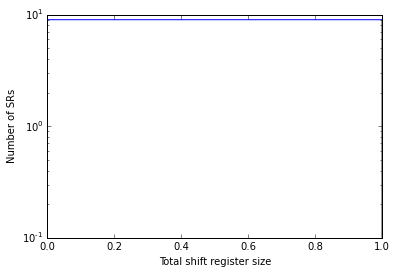

In [6]:

total_offsets = np.array(nfifo_outputs.values())
bulk_sizes = np.array(bulk_fifo_sizes.values())
fanout_sizes = np.array(fanout_fifo_sizes.values())

def print_sr_stats(all_offsets):
    print 'Total SR entries', sum(all_offsets)
    print 'Number of SR length ==0', sum(all_offsets == 0)
    print 'Number of SR length ==1', sum(all_offsets == 1)
    print 'Number of SR length ==2', sum(all_offsets == 2)
    print 'Number of SR length >=1', sum(all_offsets >= 1)
    print 'Number of SR length <=16', sum(all_offsets <= 16)
    print 'Number of SR length <=32', sum(all_offsets <= 32)
    print 'Number of SR length <=64', sum(all_offsets <= 64)
    print 'Number of SR length >64', sum(all_offsets >64)
    print 'Number of SR length >128', sum(all_offsets >128)
    print 'Number of SR length >256', sum(all_offsets >256)
    print 'Number of SR length >512', sum(all_offsets >512)

    print 'Max SR length', max(all_offsets)

print '*'*8, 'total'
print_sr_stats(total_offsets)

print '*'*8, 'bulk'
print_sr_stats(bulk_sizes)

print '*'*8, 'fanout'
print_sr_stats(fanout_sizes)

x = hist(all_offsets, np.arange(0, max(all_offsets), 1), log=True, histtype='step')
xlabel('Total shift register size')
ylabel('Number of SRs')

Total offsets 8  total sum operations 10


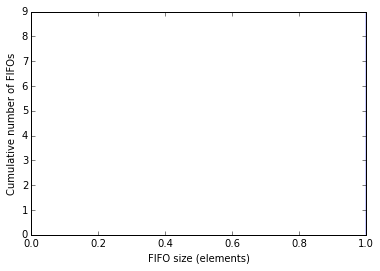

In [7]:
print 'Total offsets', sum(all_offsets), ' total sum operations', len(all_offsets)
hist(all_offsets, np.arange(0, max(all_offsets), 1), log=False, cumulative=True, histtype='step')
xlabel('FIFO size (elements)')
ylabel('Cumulative number of FIFOs')


#xlim(0, 50)

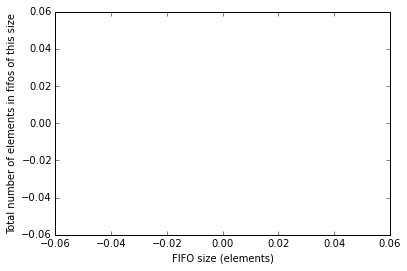

In [8]:
plot(x[1][0:-1], x[0]*(x[1][0:-1]))
xlabel('FIFO size (elements)')
ylabel('Total number of elements in fifos of this size')

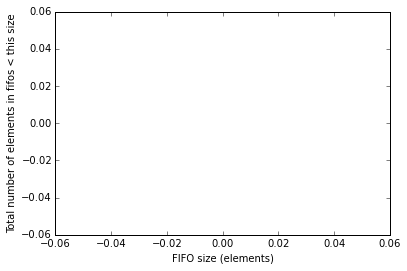

In [9]:
plot(x[1][0:-1], np.cumsum(x[0]*(x[1][0:-1])))
xlabel('FIFO size (elements)')
ylabel('Total number of elements in fifos < this size')

In [10]:
num_outputs = [len(ff) for ff in output_fifo_sizes.values()]
max_ff_length = [max(ff) for ff in output_fifo_sizes.values()]
ff_length_range = [max(ff) - min(ff) for ff in output_fifo_sizes.values()]

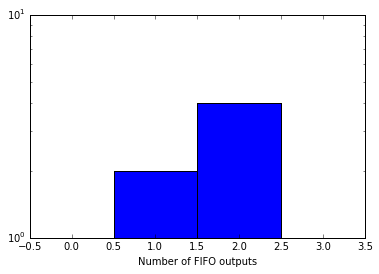

In [11]:
hist(num_outputs, np.arange(0, max(num_outputs)+3) - 0.5, log=True)
xlabel('Number of FIFO outputs')

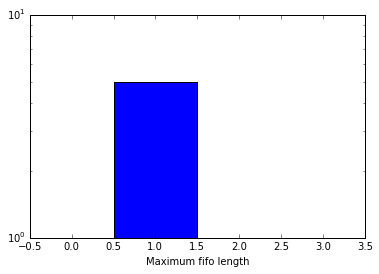

In [12]:
hist(max_ff_length, np.arange(0, max(max_ff_length)+3) - 0.5, log=True)
xlabel('Maximum fifo length')

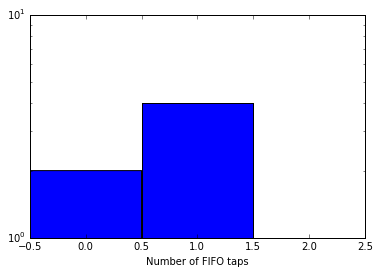

In [13]:
hist(ff_length_range, np.arange(0, max(ff_length_range)+3) - 0.5, log=True)
xlabel('Number of FIFO taps')

In [16]:
def make_c_file(thefdmt):
    all_offsets = []
    output_fifo_sizes = OrderedDict()
    # make initial nodes
    preamble = '''// 
// FDMT produced by FDMT one samlpe at a time.ipynb
// nd={f.max_dt} nf={f.n_f} fmin={f.f_min} nchan={f.n_f} df={f.d_f} bw={f.bw}
//

'''.format(f=thefdmt)
    ishape = thefdmt.hist_state_shape[0]
    read = '// Read inputs\n'
    for c in xrange(ishape[0]):
        for d in xrange(ishape[1]):
            read += 'fdmt_t {} = in[{}][{}];\n'.format(fmt(0, c, d), d,c)


    queuedecl = '// FIFO declarations\n\n'
    queuepush = '// FIFO push statements\n\n'
    do_sums = ''
    for iterno, nfd in enumerate(thefdmt.hist_nf_data):
        out_shape = thefdmt.hist_state_shape[iterno+1]
        in_shape = thefdmt.hist_state_shape[iterno]
        nchan, ndt, nt_out = out_shape
        print 'Iteration {} in={} size={} out={} size={}'.format(iterno+1, in_shape[0:2], in_shape[0:2].prod(), out_shape[0:2], out_shape[:2].prod())
        
        do_sums += '\n\n// Iteration {} in={} size={} out={} size={} \n\n'.format(iterno+1, in_shape, in_shape[0:2].prod(), out_shape, out_shape[:2].prod())
        
        for ochan in xrange(nchan):
            chanconfig = thefdmt.hist_nf_data[iterno][ochan][-1]
            #print '\tOut channel {}'.format(ochan)
            last_id1 = -1
            last_id2 = -1
            
            do_sums += '\n // Output channel {}\n'.format(ochan)
            for idt, config in enumerate(chanconfig):
                _, id1, offset, id2, _, _, _ = config
                do_copy = id2 == -1
                inchan1 = 2*ochan
                inchan2 = inchan1+1

                #print '\t Out Channel {} idout={} from chan{}/idt{}{} + chan{}/idt{}{} with offset {}' \
                #    .format(ochan, idt, inchan1, id1, id1_hit, inchan2, id2, id2_hit, offset)

                all_offsets.append(offset)

                n1 = fmt(iterno, inchan1, id1)
                n2 = fmt(iterno, inchan2, id2)
                nout = fmt(iterno+1,ochan, idt)
                
                # For a given sum - only maintain 1 fifo of the given max length
                ff = output_fifo_sizes.get(n2, [])
                ff.append(offset)
                output_fifo_sizes[n2] = ff
                
                
                if do_copy:
                    do_sums += 'fdmt_t {} = {};\n'.format(nout, n1)
                else:
                    if offset == 0:
                        do_sums += 'fdmt_t {} = {} + {};\n'.format(nout, n1, n2)
                    else:
                        do_sums += 'fdmt_t {} = {} + {}_fifo.read({});\n'.format(nout, n1, n2, offset)
                        

    for infmt, ff_sizes in output_fifo_sizes.iteritems():
        queuedecl += 'static fdmt_fifo<{},{}> {}_fifo;\n'.format(min(ff_sizes), max(ff_sizes), infmt)
        queuedecl += '#pragma HLS ARRAY_PARTITION variable={}_fifo dim=1 complete\n'.format(infmt)

        queuepush += '{}_fifo.push({});\n'.format(infmt, infmt)
    
    # write outputs
    oshape = thefdmt.hist_state_shape[iterno+1]

    write = '\n\n// Write outputs\n\n'
    for c in xrange(oshape[0]):
        for d in xrange(oshape[1]):
            write += 'out[{}] = {};\n'.format(d, fmt(iterno+1, c, d))

                
    cfile = preamble + queuedecl + read + do_sums + queuepush + write
    
    return cfile

s = make_c_file(thefdmt)
#print s
with open('fdmt_d{f.max_dt}_c{f.n_f}_f{f.f_min}.h'.format(f=thefdmt), 'w') as fout:
    fout.write(s)
    
    

Iteration 1 in=[4 2] size=8 out=[2 3] size=6
Iteration 2 in=[2 3] size=6 out=[1 4] size=4


In [37]:
def make_c_file_v2(thefdmt):
    all_offsets = []
    output_fifo_sizes = OrderedDict()
    # make initial nodes
    preamble = '''// 
// FDMT produced by FDMT one samlpe at a time.ipynb
// nd={f.max_dt} nf={f.n_f} fmin={f.f_min} nchan={f.n_f} df={f.d_f} bw={f.bw}
//

'''.format(f=thefdmt)
    for iss, ss in enumerate(thefdmt.hist_state_shape):
        preamble += '// Iteration {} shape={}\n'.format(iss, ss)
        
    ishape = thefdmt.hist_state_shape[0]
    read = '// Read inputs\n'
    for c in xrange(ishape[0]):
        for d in xrange(ishape[1]):
            read += 'fdmt_t {} = in[{}][{}];\n'.format(fmt(0, c, d), d,c)


    queuedecl = '// FIFO declarations\n\n'
    queuepush = '// FIFO push statements\n\n'
    queuemake = '''// Giant FIFO array
    static fdmt_t* fifos[][] {
    
    };
    '''
    do_sums = ''
    for iterno, nfd in enumerate(thefdmt.hist_nf_data):
        out_shape = thefdmt.hist_state_shape[iterno+1]
        in_shape = thefdmt.hist_state_shape[iterno]
        nchan, ndt, nt_out = out_shape
        print 'Iteration {} in={} size={} out={} size={}'.format(iterno+1, in_shape[0:2], in_shape[0:2].prod(), out_shape[0:2], out_shape[:2].prod())
        
        do_sums += '\n\n// Iteration {} in={} size={} out={} size={} \n\n'.format(iterno+1, in_shape, in_shape[0:2].prod(), out_shape, out_shape[:2].prod())
        
        for ochan in xrange(nchan):
            chanconfig = thefdmt.hist_nf_data[iterno][ochan][-1]
            #print '\tOut channel {}'.format(ochan)
            last_id1 = -1
            last_id2 = -1
            
            do_sums += '\n // Output channel {}\n'.format(ochan)
            for idt, config in enumerate(chanconfig):
                _, id1, offset, id2, _, _, _ = config
                do_copy = id2 == -1
                inchan1 = 2*ochan
                inchan2 = inchan1+1

                #print '\t Out Channel {} idout={} from chan{}/idt{}{} + chan{}/idt{}{} with offset {}' \
                #    .format(ochan, idt, inchan1, id1, id1_hit, inchan2, id2, id2_hit, offset)

                all_offsets.append(offset)

                n1 = fmt(iterno, inchan1, id1)
                n2 = fmt(iterno, inchan2, id2)
                nout = fmt(iterno+1,ochan, idt)
                
                # For a given sum - only maintain 1 fifo of the given max length
                # add a 0 offset for n1 and a offset for n2
                ff = output_fifo_sizes.get(n1, [])
                ff.append(0)
                output_fifo_sizes[n1] = ff
                
                ff = output_fifo_sizes.get(n2, [])
                ff.append(offset)
                output_fifo_sizes[n2] = ff 
                
                if do_copy:
                    do_sums += 'fdmt_t {} = {};\n'.format(nout, n1)
                else:
                    if offset == 0:
                        do_sums += 'fdmt_t {} = {} + {};\n'.format(nout, n1, n2)
                    else:
                        do_sums += 'fdmt_t {} = {} + {}_fifo.read({});\n'.format(nout, n1, n2, offset)
                        

    for infmt, ff_sizes in output_fifo_sizes.iteritems():
        #queuedecl += 'static fdmt_fifo<{},{}> {}_fifo;\n'.format(min(ff_sizes), max(ff_sizes), infmt)
        queuedecl += 'static fdmt_t {}_fifo[{}];\n'.format(infmt, max(ff_sizes)+1)
        queuedecl += '#pragma HLS ARRAY_PARTITION variable={}_fifo dim=1 complete\n'.format(infmt)
        queuepush += '{}_fifo.push({});\n'.format(infmt, infmt)
        queuemake += '{}_fifo,'.format(infmt)
    
    # write outputs
    oshape = thefdmt.hist_state_shape[iterno+1]

    write = '\n\n// Write outputs\n\n'
    for c in xrange(oshape[0]):
        for d in xrange(oshape[1]):
            write += 'out[{}] = {};\n'.format(d, fmt(iterno+1, c, d))

                
    cfile = preamble + queuedecl + queuemake +  read + do_sums + queuepush + write
    
    return cfile

s = make_c_file_v2(thefdmt)
print s
with open('fdmt_d{f.max_dt}_c{f.n_f}_f{f.f_min}.h'.format(f=thefdmt), 'w') as fout:
    fout.write(s)
    

Iteration 1 in=[4 2] size=8 out=[2 3] size=6
Iteration 2 in=[2 3] size=6 out=[1 4] size=4
// 
// FDMT produced by FDMT one samlpe at a time.ipynb
// nd=4 nf=4 fmin=0.976 nchan=4 df=0.001 bw=0.004
//

// Iteration 0 shape=[  4   2 258]
// Iteration 1 shape=[  2   3 259]
// Iteration 2 shape=[  1   4 260]
// FIFO declarations

static fdmt_t I0D0C0_fifo[1];
#pragma HLS ARRAY_PARTITION variable=I0D0C0_fifo dim=1 complete
static fdmt_t I0D0C1_fifo[2];
#pragma HLS ARRAY_PARTITION variable=I0D0C1_fifo dim=1 complete
static fdmt_t I0D1C0_fifo[1];
#pragma HLS ARRAY_PARTITION variable=I0D1C0_fifo dim=1 complete
static fdmt_t I0D1C1_fifo[2];
#pragma HLS ARRAY_PARTITION variable=I0D1C1_fifo dim=1 complete
static fdmt_t I0D0C2_fifo[1];
#pragma HLS ARRAY_PARTITION variable=I0D0C2_fifo dim=1 complete
static fdmt_t I0D0C3_fifo[2];
#pragma HLS ARRAY_PARTITION variable=I0D0C3_fifo dim=1 complete
static fdmt_t I0D1C2_fifo[1];
#pragma HLS ARRAY_PARTITION variable=I0D1C2_fifo dim=1 complete
static fdmt_t I